# Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data
import pandas as pd 
path1 = "/content/drive/MyDrive/TFG_1/Datasets_procesados/train/amazonEN_train_ml.csv"
path2 = "/content/drive/MyDrive/TFG_1/Datasets_procesados/valid/amazonEN_valid_ml.csv"
path3 = "/content/drive/MyDrive/TFG_1/Datasets_procesados/test/amazonEN_test_ml.csv"
df_train = pd.read_csv(path1)
df_valid = pd.read_csv(path2)
df_test = pd.read_csv(path3)

In [ ]:
df_train.head(1)

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod,star_rating_str,0,1,2,3,4,apparel,automotive,baby_product,beauty,book,camera,digital_ebook_purchase,digital_video_download,drugstore,electronics,furniture,grocery,home,home_improvement,industrial_supplies,jewelry,kitchen,lawn_and_garden,luggage,musical_instruments,office_product,other,pc,personal_care_appliances,pet_products,shoes,sports,toy,video_games,watch,wireless
0,en_0953486,product_en_0381770,reviewer_en_0978532,4,"Great, great batteries. Arrived on time and pa...",Strip of 10 Fresh Maxell LR1130 Batteries,en,electronics,Strip of 10 Fresh Maxell LR1130 Batteries Grea...,Strip of 10 Fresh Maxell LR1130 Batteries Grea...,"Great, great batteries. Arrived on time and pa...",9,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train.shape

(200000, 49)

# Creacion lista de etiquetas 
  - Todos los nombres, star_rating + product_category

In [ ]:
multilabels_list = df_train.columns
multilabels_list = multilabels_list[13:]


In [ ]:
len(multilabels_list)

36

In [ ]:
path4 = "/content/drive/MyDrive/TFG_1/ml.csv"
df_labels = pd.read_csv(path4)
df_labels.to_csv('/content/drive/MyDrive/TFG_1/ml.csv', index=False, header=False)


In [ ]:
df_train = df_train.head(1000)
df_valid = df_valid.head(500)
df_test = df_test.head(500)

# Fast-BERT 
- importar fast-bert
- importar nvidia apex
 

In [ ]:
%%capture
!pip install fast-bert

In [ ]:
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --no-cache-dir ./

fatal: destination path 'apex' already exists and is not an empty directory.
/content/apex
Created temporary directory: /tmp/pip-ephem-wheel-cache-2dl_nmcw
Created temporary directory: /tmp/pip-req-tracker-qyo_wfku
Created requirements tracker '/tmp/pip-req-tracker-qyo_wfku'
Created temporary directory: /tmp/pip-install-8lgoqoyf
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-nhtr9fp_
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-qyo_wfku'
    Running setup.py (path:/tmp/pip-req-build-nhtr9fp_/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info


    torch.__version__  = 1.7.0+cu101


    running egg_info
    creating /tmp/pip-req-build-nhtr9fp_/pip-egg-info/apex.egg-info
    writing /tmp/pip-req-build-nhtr9fp_/pip-egg-info/apex.egg-info/PKG-INFO
    writing dependency_links to /tmp/pip-req-build-nhtr9fp_/pip-egg-info/apex.egg-info/dependency_links.txt
    writing top-level names to /tmp/

# Modelo Fast-BERT for multilabel classification

In [ ]:
from fast_bert.data_cls import BertDataBunch

# Creación objeto DataBunch

DATA_PATH = "/content/drive/MyDrive/TFG_1"
LABEL_PATH= "/content/drive/MyDrive/TFG_1"

databunch = BertDataBunch(DATA_PATH, LABEL_PATH,
                          tokenizer='bert-base-uncased',
                          train_file='train_ml.csv',
                          val_file='valid_ml.csv',
                          label_file='ml.csv',          #CSV con los nombres de las labels 
                          text_col='review_body',
                          label_col= multilabels_list,  # Lista de las labels posibles
                          batch_size_per_gpu=16,
                          max_seq_length=512,
                          multi_gpu=True,
                          multi_label=True,             # True para multilabel clasification
                          model_type='bert')

In [ ]:
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
from fast_bert.metrics import roc_auc, roc_curve
import logging
import torch 

# Creación objeto Learner 

logger = logging.getLogger()
device_cuda = torch.device("cuda")
metrics = [{'name': 'accuracy', 'function': accuracy}]


OUTPUT_DIR = "/content/drive/MyDrive/TFG_1/Modelos_entrenados/fast_bert_ml"


learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='bert-base-uncased',
						metrics=metrics,
						device=device_cuda,
						logger=logger,
						output_dir=OUTPUT_DIR,
						finetuned_wgts_path=None,
						warmup_steps=500,
						multi_gpu=True,
						is_fp16=True,
						multi_label=True,
						logging_steps=50)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not 

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


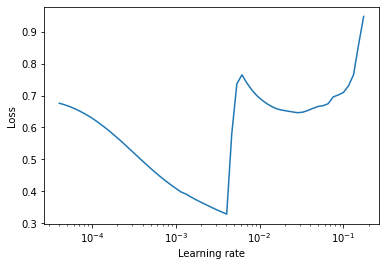

In [ ]:
#Buscador de Learning Rate óptima

learner.lr_find(start_lr=1e-5,optimizer_type='adamw')

In [ ]:
# Entrenamiento del modelo 

learner.fit(epochs=1,
			lr=10e-2,        # Learning rate escogida como optima
			validate=True, 	# Evaluate the model after each epoch
			schedule_type="warmup_cosine",
			optimizer_type="adamw")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 256.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 128.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 64.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16.0
Gradient overflow.  Skipping step, loss scaler 0 reducing l

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.3283064365386963e-10
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.1641532182693481e-10
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 5.820766091346741e-11
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.9103830456733704e-11
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.4551915228366852e-11
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 7.275957614183426e-12
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 3.637978807091713e-12
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.8189894035458565e-12
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 9.094947017729282e-13
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4.547473508864641e-13
Gradient overflow.  Skipping step, loss scaler 0 reduci

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.0679515313825692e-25
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0339757656912846e-25
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 5.169878828456423e-26
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.5849394142282115e-26
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.2924697071141057e-26
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 6.462348535570529e-27
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 3.2311742677852644e-27
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.6155871338926322e-27
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8.077935669463161e-28
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4.0389678347315804e-28
Gradient overflow.  Skipping step, loss scaler 0 redu

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.8367099231598242e-40
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 9.183549615799121e-41
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4.591774807899561e-41
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.2958874039497803e-41
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.1479437019748901e-41
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 5.739718509874451e-42
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.8698592549372254e-42
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.4349296274686127e-42
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 7.174648137343064e-43
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 3.587324068671532e-43
Gradient overflow.  Skipping step, loss scaler 0 reduci

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.6313261169996311e-55
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8.156630584998156e-56
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4.078315292499078e-56
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.039157646249539e-56
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0195788231247695e-56
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 5.0978941156238473e-57
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.5489470578119236e-57
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.2744735289059618e-57
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 6.372367644529809e-58
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 3.1861838222649046e-58
Gradient overflow.  Skipping step, loss scaler 0 reduc

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.448908652612274e-70
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 7.24454326306137e-71
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 3.622271631530685e-71
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.8111358157653425e-71
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 9.055679078826712e-72
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4.527839539413356e-72
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.263919769706678e-72
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.131959884853339e-72
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 5.659799424266695e-73
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.8298997121333476e-73
Gradient overflow.  Skipping step, loss scaler 0 reducing l

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.2868893973670072e-85
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 6.434446986835036e-86
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 3.217223493417518e-86
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.608611746708759e-86
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8.043058733543795e-87
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4.021529366771898e-87
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.010764683385949e-87
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.0053823416929744e-87
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 5.026911708464872e-88
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.513455854232436e-88
Gradient overflow.  Skipping step, loss scaler 0 reducing 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.142987391282275e-100
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 5.714936956411375e-101
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.8574684782056875e-101
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.4287342391028437e-101
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 7.143671195514219e-102
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 3.5718355977571093e-102
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1.7859177988785547e-102
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8.929588994392773e-103
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4.464794497196387e-103
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2.2323972485981933e-103
Gradient overflow.  Skipping step, loss scale

(625, nan)

In [ ]:
# Guardar el modelo

learner.save_model()

# Evaluación del Modelo

In [ ]:
texts = ['I really love this chair product']
predictions = learner.predict_batch(texts)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


In [ ]:
predictions   ## todo es NaN, no puede estar funcionando bien 

[[('0', nan),
  ('1', nan),
  ('2', nan),
  ('3', nan),
  ('4', nan),
  ('apparel', nan),
  ('automotive', nan),
  ('baby_product', nan),
  ('beauty', nan),
  ('book', nan),
  ('camera', nan),
  ('digital_ebook_purchase', nan),
  ('digital_video_download', nan),
  ('drugstore', nan),
  ('electronics', nan),
  ('furniture', nan),
  ('grocery', nan),
  ('home', nan),
  ('home_improvement', nan),
  ('industrial_supplies', nan),
  ('jewelry', nan),
  ('kitchen', nan),
  ('lawn_and_garden', nan),
  ('luggage', nan),
  ('musical_instruments', nan),
  ('office_product', nan),
  ('other', nan),
  ('pc', nan),
  ('personal_care_appliances', nan),
  ('pet_products', nan),
  ('shoes', nan),
  ('sports', nan),
  ('toy', nan),
  ('video_games', nan),
  ('watch', nan),
  ('wireless', nan)]]

In [ ]:
!pip install tensorboard

In [ ]:
#!tensorboard --logdir=/content/drive/MyDrive/Modelos_entrenados/fast_bert_ml/tensorboard

2021-02-22 13:37:47.810285: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.4.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
from fast_bert.prediction import BertClassificationPredictor


In [ ]:
predictor = BertClassificationPredictor(args.output_dir/'model_out', args.output_dir, "/content/drive/MyDrive/TFG_1/ml.csv", 
                                        multi_label=True, model_type='bert', do_lower_case=False)

NameError: ignored

In [ ]:
output = predictor.predict_batch(list(pd.read_csv("../data/test.csv")['comment_text'].values))

In [ ]:
pd.DataFrame(output).to_csv('../data/output_xlnet.csv')

In [ ]:
results = pd.read_csv('../data/output_xlnet.csv')
preds = pd.DataFrame([{item[0]: item[1] for item in pred} for pred in output])

In [ ]:
preds.head()

In [ ]:
test_df = pd.read_csv("../data/train.csv")
test_df.head()